<a href="https://colab.research.google.com/github/UltimateBlue/Python/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import liberaries

In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from urllib.request import urlretrieve

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets.utils import download_url

import zipfile
from zipfile import ZipFile

import pandas as pd
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


import torch.optim as optim

import pdb


#Model

In [ ]:
torch.set_default_dtype(torch.float64)

#  nn.Linear( num_of_inputs , num_of_outputs )   -->  one layer of "num_of_outputs" neurons
class Gate(nn.Module):
  #  input: x    ...........  output: x_partial
  def __init__(self, n, tow):
    super(Gate, self).__init__()
    self.gate_model = nn.Linear(n, n)
    self.tow = tow
  def forward(self, x):
    y = self.gate_model(x)
    sigmoid = nn.Sigmoid()
    z_g = sigmoid(y)
    output = (z_g>self.tow).float()*1
    x_partial = x * output
    return x_partial, z_g
  # def loss(self):
  #   pass


class Encoder(nn.Module):
  #  input: x_partial    ...........  output: h
  # n_layers: a list containing number of neurons in each layer of encoder
  def __init__(self, n_layers, n, n_prim):
    super(Encoder, self).__init__()
    self.enc_layer = []
    self.n_layer = [n] + n_layers + [n_prim]
    self.layers = len(n_layers) + 1
    for i in range(self.layers):
      self.enc_layer.append(nn.Linear(self.n_layer[i], self.n_layer[i+1]))
  def forward(self, x):
    for i in range(self.layers):
      x = torch.relu(self.enc_layer[i](x))
    h = x
    return h

class Decoder(nn.Module):
  #  input: h    ...........  output: x
  def __init__(self, n_layers, n, n_prim):
    super(Decoder, self).__init__()
    self.dec_layer = []
    self.n_layer = [n_prim] + n_layers + [n]
    self.layers = len(n_layers) + 1
    for i in range(self.layers):
      self.dec_layer.append(nn.Linear(self.n_layer[i], self.n_layer[i+1]))
  def forward(self, x):
    for i in range(self.layers-1):
      x = torch.relu(self.dec_layer[i](x))
    x  = torch.sigmoid(self.dec_layer[self.layers-1](x))
    x_hat = x
    return x_hat


class Classifier(nn.Module):
    def __init__(self, n_prim,classes):
        super(Classifier, self).__init__()
        self.clsfier = nn.Linear(n_prim, classes)
    def forward(self, h):
        out = self.clsfier(h)
        out_probs = F.softmax(out, dim=1)
        max_probs, preds = torch.max(out_probs, dim=1, keepdim=False)
        return out_probs  , preds
    def loss_func(self, probs, labels):
      # m = nn.Sigmoid()
      # loss_fn = nn.BCELoss()
      # output = loss(m(input), labels)
      # output.backward()
      loss_fn = F.cross_entropy
      # loss = loss_fn(probs, labels, reduction='sum').item()
      loss = loss_fn(probs, labels.type(torch.LongTensor))
      return loss
    def accuracy(self, preds, labels):
      return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    # def validation_step(self, val_ld):
    #     features, labels = val_ld
    #     probs  , preds = self(features)
    #     loss = F.cross_entropy(probs, labels)
    #     acc = self.accuracy(preds, labels)
    #     return {'val_loss': loss, 'val_acc': acc}

    # def validation_epoch_end(self, outputs):
    #     batch_losses = [x['val_loss'] for x in outputs]
    #     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    #     batch_accs = [x['val_acc'] for x in outputs]
    #     epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    #     return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # def epoch_end(self, epoch, result):
    #     print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



class PISAE(nn.Module):
  def __init__(self, params):
  # def __init__(self, n_layers, n, n_prim, classes, tow, ro):
    super(PISAE, self).__init__()
    self.ro = params['ro']
    self.tow = params['tow']
    self.n = params['sensors']
    self.beta1 = params['beta1']
    self.beta2 = params['beta2']
    self.beta3 = params['beta3']
    self.n_prim = params['n_prim']
    self.n_layers = params['n_layers']
    self.batch_size = params['batch_size']
    self.fc1 = Gate(self.n, self.tow)
    self.fc2 = Encoder(self.n_layers, self.n, self.n_prim)
    self.n_layers.reverse()
    self.fc3 = Decoder(self.n_layers, self.n, self.n_prim)
    # self.fc4 = Classifier(self.n_prim, params['classes'])
  def forward(self, x):
    x_partial, z_g = self.fc1(x)
    hx = self.fc2(x_partial)
    x_hat = self.fc3(hx)
    # preds = self.fc4(hx)
    return z_g, x_partial, hx, x_hat #, preds

  def loss_func(self, x, z_g, x_partial, hx, x_hat):
    loss_Jr = nn.MSELoss()

    ro_hat = torch.sum(hx, dim=0, keepdim=False)/len(hx)
    ########################## Handed ##########################
    # J_kl = 0
    # for p in ro_hat:
    #   if p != 0 and p != 0.0 and p != 1 and p != 1.0:
    #     J_kl += (self.ro * torch.log(self.ro/p) + (1-self.ro) * torch.log((1-self.ro)/(1-p)))
    #     # print(f'DEBUGGER .............................p: {p}')
    ########################## torch ###########################
    # print(f'DEBUGGER................... {self.ro*torch.ones_like(ro_hat)}')
    # print(f'DEBUGGER................... {torch.softmax(self.ro*torch.ones_like(ro_hat), dim = 0)}')
    # print(f'DEBUGGER................... {ro_hat}')
    p = torch.log(F.softmax(self.ro*torch.ones_like(ro_hat), dim = 0))
    q = F.softmax(ro_hat, dim = 0)
    epsilon = 1e-8
    p = p + epsilon
    q = q + epsilon
    J_kl = F.kl_div(p, q , reduction='batchmean').item()

    comp_fact = torch.sum(torch.abs(z_g))/(self.batch_size *len(x[0])) # NOT CORRECT!!!!!!!!!!!
    J_r = loss_Jr(x, x_hat)


    # J_kl = 5*self.kl_divergence(self.ro*torch.ones_like(ro_hat), ro_hat)
    # class_loss = self.fc4.loss_func(preds, labels)
    # class_loss = 1

    loss = J_r + self.beta1 * J_kl + self.beta2 * comp_fact  # + self.beta3 * class_loss
    # loss = J_r
    # print(f'jr is: {J_r.item()}')
    # return loss_AE, loss_total
    # mse_l  = nn.MSELoss()
    # print(f'DEBUGGER............................. {J_kl}, .. {comp_fact}')

    return loss

In [ ]:
def data_prep(batch_size):
  """ Data Preparation """
  url = 'https://archive.ics.uci.edu/static/public/52/ionosphere.zip'
  urlretrieve(url, './ionosphere.zip')
  with ZipFile("ionosphere.zip", 'r') as z:
      z.extractall(path="./data")

  # read data file and set column names
  df = pd.read_csv('./data/ionosphere.data', header=None)
  df.columns = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20',
                '21','22','23','24','25','26','27','28','29','30',
                '31','32','33','34','35']
  # convert all datatypes to numeric types
  for d,i in zip(df['35'], range(0,351)):
    if d == 'b':
      df.at[i,'35'] = 0.
    elif d == 'g':
      df.at[i,'35'] = 1.

  df = df.astype({'35':'float'})


  # convert pandas dataframe to numpy array
  data = df.values
  data = torch.from_numpy(data)
  # data.type(torch.FloatTensor)

  inputs = torch.tensor(df.iloc[:,0:34].values)
  targets = torch.tensor(df.iloc[:,34].values)
  # print('------------------------------------------------------')
  # print(inputs[0:3])
  # print(targets)
  # print('------------------------------------------------------')

  # create a TensorDataset, which allows access to rows from inputs and targets as tuples.
  # access to 9th data as:    input, label = dataset[9]
  # inputs = data[:,0:34]
  # targets = data[:, 34]

  # # input normalization

  # inputs_std = torch.std(inputs, dim=0)
  # # print(inputs_std.shape)

  # inputs_mean = torch.mean(inputs, dim=0)
  # # print(inputs_mean)
  # # print(inputs)
  # inputs = (inputs - inputs_mean) #/ inputs_std
  # for i, d in enumerate(inputs_std):
  #   if d==0 or d==0.0:
  #     inputs_std = 1.
  # inputs = inputs/inputs_std

  # print(inputs)

  ds = TensorDataset(inputs, targets)


  # split the whole data to train, validation and test sets
  tr_size = int(len(data)*.6)
  vl_size = int(len(data)*.2)
  ts_size = len(data) - tr_size - vl_size
  train_set, val_set, test_set = random_split(ds, [tr_size, vl_size, ts_size])

  # Create data batches
  # batch_size = 128
  train_dl = DataLoader(train_set, batch_size, shuffle=True)
  val_dl = DataLoader(val_set, batch_size)
  test_dl = DataLoader(test_set, batch_size)
  return train_dl, val_dl, test_dl

In [ ]:
def train(x, labels, optimizer, optimizer_cls, pisae, classifier):

  optimizer.zero_grad()
  optimizer_cls.zero_grad()

  z_g, x_partial, hx, x_hat = pisae(x)
  h = hx.detach()
  out_probs  , preds = classifier(h)

  loss_pisae = pisae.loss_func(x, z_g, x_partial, hx, x_hat)
  loss_cls = classifier.loss_func(out_probs, labels)
  acc_cls = classifier.accuracy(preds, labels)

  loss_pisae.backward()
  loss_cls.backward(retain_graph=True)

  optimizer.step()
  optimizer_cls.step()


  return loss_pisae, loss_cls, acc_cls

In [ ]:
def test(x, labels, pisae, classifier):

  z_g, x_partial, hx, x_hat = pisae(x)
  h = hx.detach()
  probs, preds = classifier(h)
  # print(f'DEBUGGER...................... {type(labels)}.... {type(preds)}')
  loss_pisae = pisae.loss_func(x, z_g, x_partial, hx, x_hat)
  loss_cls = classifier.loss_func(probs, labels)
  acc_cls = classifier.accuracy(preds, labels)



  # correct += preds.eq(labels.view_as(preds)).sum().item() # ....
  return loss_pisae, loss_cls, acc_cls

In [ ]:
def plot_results(loss_tr, acc_tr, cls_tr, loss_ts, acc_ts, cls_ts, epoch, plt_interval):
    # sns.set_style("whitegrid")
  %matplotlib inline
  matplotlib.rcParams['font.size'] = 5
  matplotlib.rcParams['figure.figsize'] = (10,8)
  matplotlib.rcParams['figure.facecolor'] = '#FFFBBB'
  matplotlib.rcParams['lines.linewidth'] = .7
  # plt.style.use('fivethirtyeight')


  # plt.figure(figsize=(20,20))
  fig, axes = plt.subplots(2,3)

  axes[0,0].set_xlabel('Iterations')
  axes[0,0].set_ylabel('Train Loss')
  axes[0,1].set_xlabel('Iterations')
  axes[0,1].set_ylabel('Train Acc')
  axes[0,2].set_xlabel('Iterations')
  axes[0,2].set_ylabel('Train clsLoss')
  axes[1,0].set_xlabel('Iterations')
  axes[1,0].set_ylabel('Test Loss')
  axes[1,1].set_xlabel('Iterations')
  axes[1,1].set_ylabel('Test Acc')
  axes[1,2].set_xlabel('Iterations')
  axes[1,2].set_ylabel('Test clsLoss')

  axes[0,0].plot(list(np.arange(0,epoch, plt_interval)), loss_tr)
  axes[0,1].plot(list(np.arange(0,epoch, plt_interval)), acc_tr)
  axes[0,2].plot(list(np.arange(0,epoch, plt_interval)), cls_tr)
  axes[1,0].plot(list(np.arange(0,len(loss_ts))), loss_ts)
  axes[1,1].plot(list(np.arange(0,len(loss_ts))), acc_ts)
  axes[1,2].plot(list(np.arange(0,len(loss_ts))), cls_ts)
  plt.show()

In [ ]:
def main(*args):
  params = {'epoch': 300,
                'zeta': 0.0001, # learning rate
                'beta1': 2, #
                'beta2': .001,
                'beta3': 3, # classification importance coefficient
                'tow': .1,  # threshold
                'ro': .5,   # sparsity parameter
                'n_prim': 20, # number of neurons in the AE hidden layer
                'm': 351,  # number of the whole data
                'sensors': 34,  # n
                'batch_size': 5,
                'classes': 2,
                'plot_interval': 5,
            'n_layers': []
  }

  train_dl, val_dl, test_dl = data_prep(params['batch_size'])
  # vl_features, vl_targets = seprate_features(val_dl)
  # ts_features, ts_targets = seprate_features(test_dl)
  # for step, (batch, label) in enumerate(trian_dl):
  #   n = len(batch[0,:])
  #   break

  # n_layers = [params['sensors'], params['sensors']-2]
  # def __init__(self, n_layers, n, n_prim, classes, tow):
  # pisae = PISAE(params['n_layers'], params['sensors'], params['n_prim'], params['classes'],params['tow'],params['ro'])
  pisae = PISAE(params)
  classifier = Classifier(params['n_prim'], params['classes'])
  # print(f'DEBUGGER................................{classifier.parameters()}')
  optimizer = optim.Adam(pisae.parameters(), lr = params['zeta'])
  optimizer_cls = optim.SGD(classifier.parameters(), lr = params['zeta'])

  # torch.set_grad_enabled(True)  # Context-manager


  # training loop
  loss_tr = []
  acc_tr = []
  cls_tr = []
  pisae.train()
  classifier.train()
  for i in range(params['epoch']):
    for step, (data, labels) in enumerate(train_dl):
      loss_total, loss_acc, loss_cls = train(data, labels, optimizer, optimizer_cls, pisae, classifier)
    # collect plotting data
    if i % params['plot_interval'] == 0:
      loss_tr.append(loss_total.item())
      acc_tr.append(loss_acc.item())
      cls_tr.append(loss_cls.item())
      print(f'Train loss in epoch {i} is {loss_total.item()}')

  # test loop
  pisae.eval()
  classifier.eval()
  loss_ts = []
  acc_ts = []
  cls_ts = []
  with torch.inference_mode():
    for step, (data, labels) in enumerate(test_dl):
      loss_total, loss_acc, loss_cls = test(data, labels, pisae, classifier)
      # collect plotting data
      loss_ts.append(loss_total.item())
      acc_ts.append(loss_acc.item())
      cls_ts.append(loss_cls.item())
      print(f'Test loss in run {step} is {loss_total.item()}')



  # plot training results
  plot_results(loss_tr, acc_tr, cls_tr, loss_ts, acc_ts, cls_ts, params['epoch'], params['plot_interval'])

Train loss in epoch 0 is 0.3534831799443568
Train loss in epoch 5 is 0.3661545623317624
Train loss in epoch 10 is 0.3613875902713764
Train loss in epoch 15 is 0.39242484353471163
Train loss in epoch 20 is 0.4126426965792901
Train loss in epoch 25 is 0.37310857667812003
Train loss in epoch 30 is 0.23708039898659405
Train loss in epoch 35 is 0.2836530848198549
Train loss in epoch 40 is 0.42941909675262785
Train loss in epoch 45 is 0.2829135042838724
Train loss in epoch 50 is 0.5019829835966005
Train loss in epoch 55 is 0.4480499186684099
Train loss in epoch 60 is 0.6343515413986899
Train loss in epoch 65 is 0.3727261724976465
Train loss in epoch 70 is 0.4065919721326794
Train loss in epoch 75 is 0.3108005429313197
Train loss in epoch 80 is 0.29655153692049846
Train loss in epoch 85 is 0.3655626085713729
Train loss in epoch 90 is 0.5114530886131614
Train loss in epoch 95 is 0.511015953955209
Train loss in epoch 100 is 0.31165363174673466
Train loss in epoch 105 is 0.34990241269905165
Trai

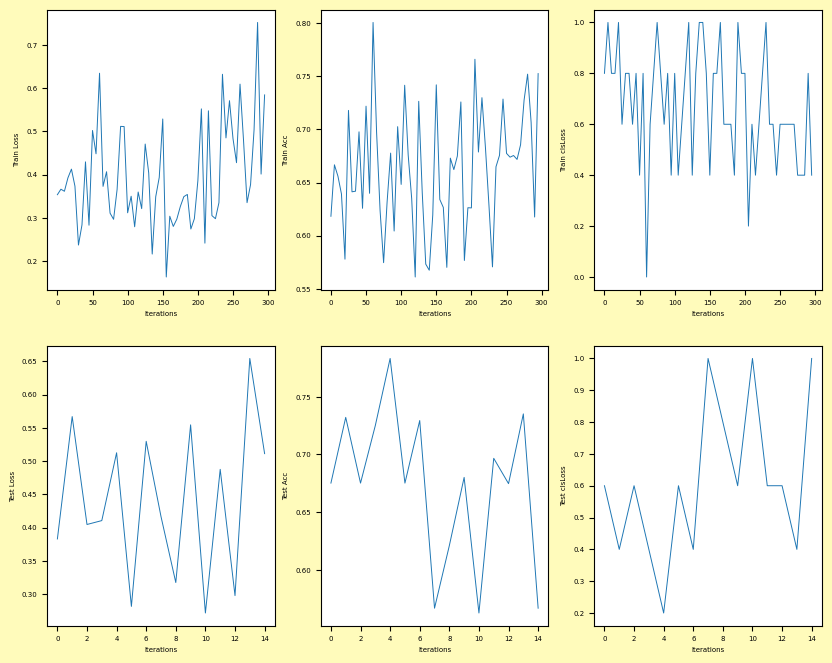

In [ ]:
main()